# 1. EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data/orig/DBP_wiki_data.csv")
print(len(df))
df.head(2)

342781


,text,l1,l2,l3,wiki_name,word_count
0,The 1994 Mindoro earthquake occurred on Novemb...,Event,NaturalEvent,Earthquake,1994_Mindoro_earthquake,59
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event,NaturalEvent,Earthquake,1917_Bali_earthquake,68


<AxesSubplot:>

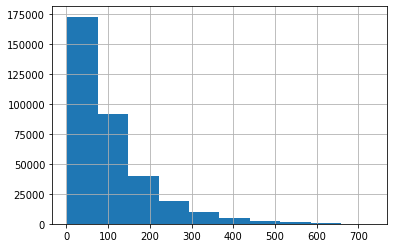

In [3]:
# Word count
df["word_count"].hist(bins=10)

<AxesSubplot:>

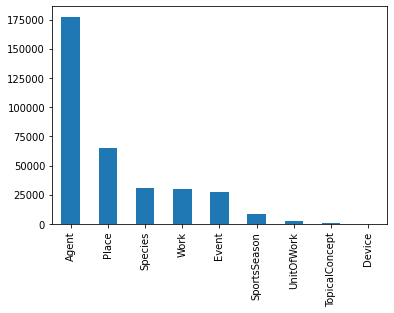

In [4]:
# Level 1
df["l1"].value_counts().plot(kind="bar")

<AxesSubplot:>

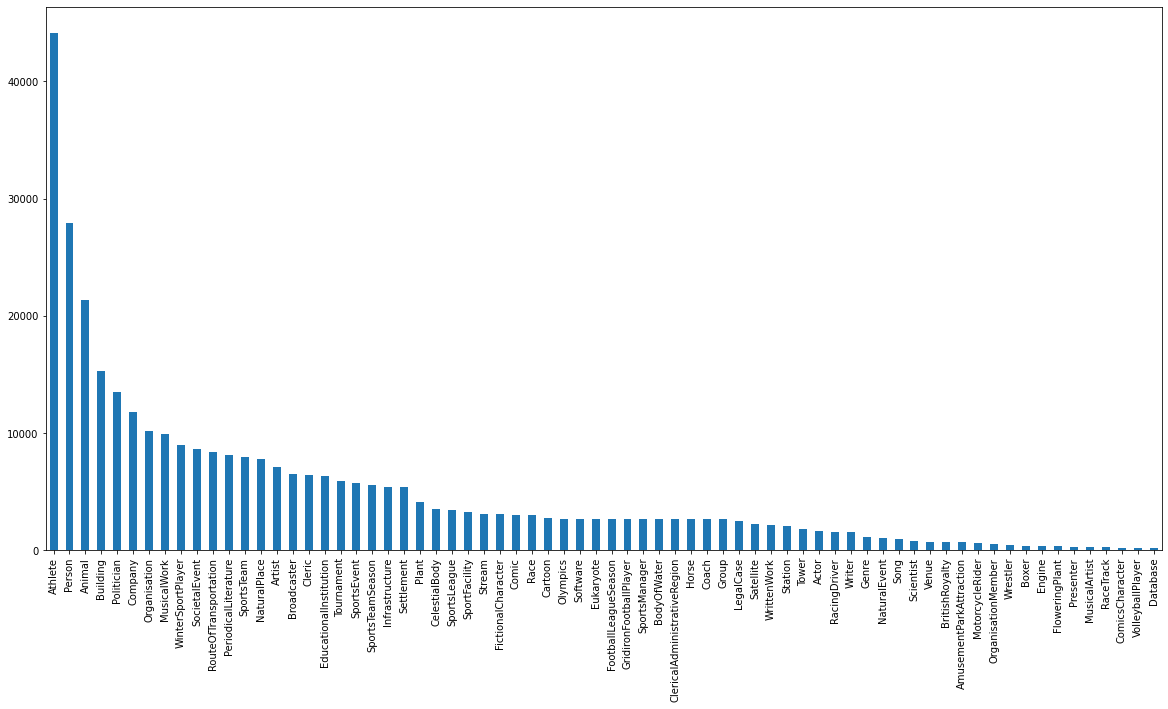

In [5]:
# Level 2
plt.figure(figsize=(20, 10))
df["l2"].value_counts().plot(kind="bar")

<AxesSubplot:>

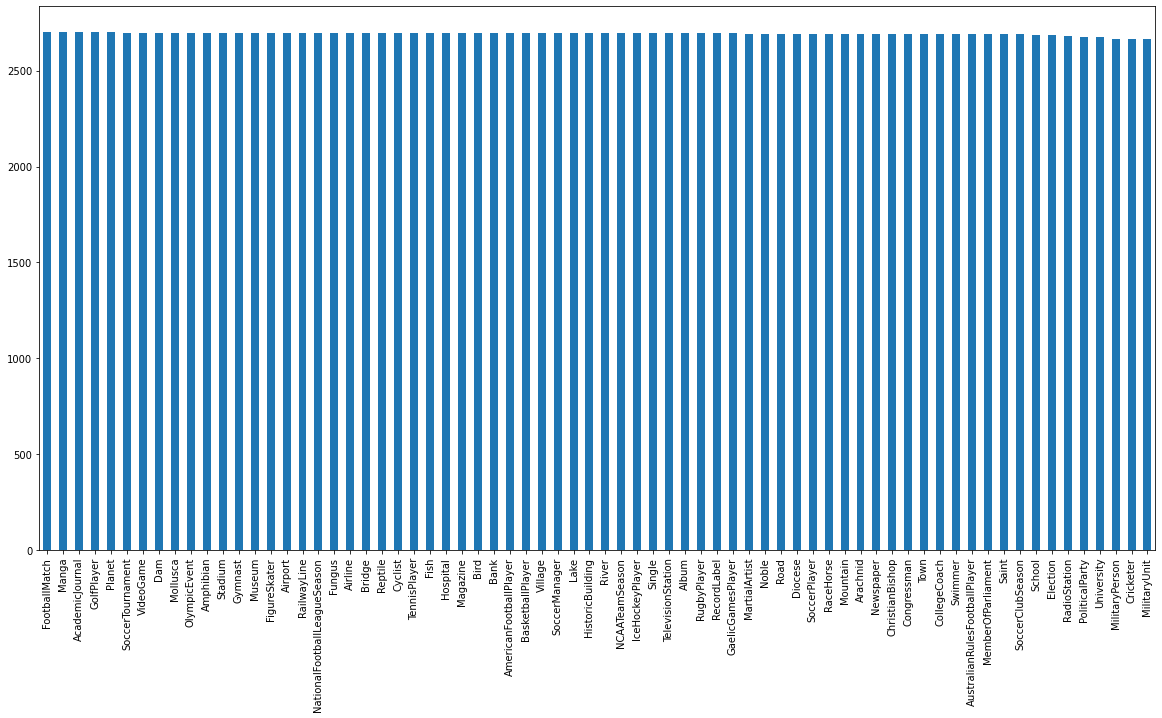

In [6]:
# Level 2
plt.figure(figsize=(20, 10))
df["l3"].value_counts().iloc[:70].plot(kind="bar")

### Seems like level 3 categories are equally distributed

# 2. Stratified sampling based on all three levels

In [1]:
import os
import math
import json

import pandas as pd

In [2]:
num_folds = 10
src_path = "data/orig/DBP_wiki_data.csv"
dest_dir = "data/processed/"

In [3]:
df = pd.read_csv(src_path)
print(len(df))
df.head(2)

342781


,text,l1,l2,l3,wiki_name,word_count
0,The 1994 Mindoro earthquake occurred on Novemb...,Event,NaturalEvent,Earthquake,1994_Mindoro_earthquake,59
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event,NaturalEvent,Earthquake,1917_Bali_earthquake,68


In [4]:
folds = [[] for _ in range(num_folds)]
df = df.sample(frac=1.0, random_state=136)

for _, sub_df in df.groupby(["l1", "l2", "l3"]):
    size = math.ceil(len(sub_df) / num_folds)

    for i in range(num_folds):
        start = i * size
        end = min((i + 1) * size, len(sub_df))
        folds[i].append(sub_df.iloc[start:end])

folds = [pd.concat(fold, ignore_index=True) for fold in folds]
print([len(fold) for fold in folds])
folds[0].head(2)

[34374, 34374, 34374, 34374, 34374, 34374, 34374, 34374, 34374, 33415]


,text,l1,l2,l3,wiki_name,word_count
0,(Not to be confused with Katja K.) Katja Kassi...,Agent,Actor,AdultActor,Katja_Kassin,22
1,"Céline Bara, née Céline Szumigay, (9 September...",Agent,Actor,AdultActor,Céline_Bara,19


In [5]:
# Save
for i, fold in enumerate(folds):
    save_path = os.path.join(dest_dir, f"split_{i}.csv")
    fold.to_csv(save_path, index=False)

In [6]:
# Generate mapping
mapping = {}

for level in ["l1", "l2", "l3"]:
    cat = df[level].unique()
    ids = range(len(cat))

    cls2idx = dict(zip(cat, ids))
    idx2cls = dict(zip(ids, cat))
    mapping[level] = {"cls2idx": cls2idx, "idx2cls": idx2cls}

with open("data/processed/mapping.json", "w") as fout:
    json.dump(mapping, fout)